In [1]:
import tensorflow as tf

import os
import hickle as hkl
import numpy as np
import pandas as pd
%run ../src/preprocessing/indices.py

In [2]:
#predict_model_path = "../models/75-composite-masterfeb9/"
predict_model_path = "../models/epoch31/"
predict_model_path2 = "../models/epoch31/"


In [3]:
        
predict_graph_def = tf.compat.v1.GraphDef()
predict_graph_def2 = tf.compat.v1.GraphDef()
if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path2}")
    predict_file2 = tf.io.gfile.GFile(predict_model_path2 + "predict_graph.pb", 'rb')
    predict_graph_def2.ParseFromString(predict_file2.read())
    predict_graph2 = tf.import_graph_def(predict_graph_def2, name='predict2')
    predict_sess2 = tf.compat.v1.Session(graph=predict_graph2)
    predict_logits2 = predict_sess2.graph.get_tensor_by_name(f"predict2/conv2d_5/Sigmoid:0") 
    #predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/clip_by_value:0") 
    #feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    feature_extraction_initial2 = predict_sess2.graph.get_tensor_by_name(
        "predict2/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp2 = predict_sess2.graph.get_tensor_by_name("predict2/Placeholder:0")
    predict_length2 = predict_sess2.graph.get_tensor_by_name("predict2/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")

if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path}")
    predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
    predict_graph_def.ParseFromString(predict_file.read())
    predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
    predict_sess = tf.compat.v1.Session(graph=predict_graph)
    predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_5/Sigmoid:0") 
    #predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/clip_by_value:0") 
    #feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
        "predict/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
    predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")
    


Loading model from ../models/epoch31/
Loading model from ../models/epoch31/


In [4]:
SIZE = 158
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434,
           0.7472037842374304, 0.7000076295109483, 0.4, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

min_all = np.array(min_all)
max_all = np.array(max_all)
min_all = np.broadcast_to(min_all, (1, SIZE + 14, SIZE + 14, 17)).astype(np.float32)
max_all = np.broadcast_to(max_all, (1, SIZE + 14, SIZE + 14, 17)).astype(np.float32)
midrange = (max_all + min_all) / 2
midrange = midrange.astype(np.float32)
rng = max_all - min_all
rng = rng.astype(np.float32)

In [5]:

def convert_to_db(x: np.ndarray, min_db: int) -> np.ndarray:
    """ Converts unitless backscatter coefficient
        to db with a min_db lower threshold
        
        Parameters:
         x (np.ndarray): unitless backscatter (T, X, Y, B) array
         min_db (int): integer from -50 to 0
    
        Returns:
         x (np.ndarray): db backscatter (T, X, Y, B) array
    """
    
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = (x + min_db) / min_db
    return np.clip(x, 0, 1)

import pandas as pd
%run ../src/preprocessing/indices.py
source = 'train'
fname = 'positives'
#x = hkl.load(f"../data/{source}/{source}_x3.hkl")
test_x = hkl.load(f"../notebooks/development/test_x.hkl")
test_x = np.delete(test_x, 11, -1)

if not isinstance(test_x.flat[0], np.floating):
    assert np.max(test_x) > 1
    test_x = test_x / 65535.

test_x = np.float32(test_x)
test_x[..., -1] = convert_to_db(test_x[..., -1], 22)
test_x[..., -2] = convert_to_db(test_x[..., -2], 22)

#s1 = test_x[..., 11:13]
#s1 = np.reshape(s1, (s1.shape[0], s1.shape[1], 12, 2, 12, 2, 2))
#s1 = np.mean(s1, axis = (3, 5))
#s1 = resize(s1, (s1.shape[0], 12, 24, 24, 2), order = 0)
#test_x[..., 11:13] = s1

indices = np.zeros((test_x.shape[0], 12, 28, 28, 4), dtype = np.float32)
indices[..., 0] = evi(test_x)
indices[..., 1] = bi(test_x)
indices[..., 2] = msavi2(test_x)
indices[..., 3] = grndvi(test_x)
#indices[..., 4] = ndwi(test_x)
#indices[..., 5] = ndmi(test_x)

test_x = np.concatenate([test_x, indices], axis = -1)

test_x = np.reshape(test_x, (test_x.shape[0], 4, 3, 28, 28, 17))
test_x = np.median(test_x, axis = 2, overwrite_input = True)

med = np.median(test_x, axis = 1)
med = med[:, np.newaxis, :, :, :]
test_x = np.concatenate([test_x, med], axis = 1)
print(test_x.shape)
test_y = hkl.load(f"../notebooks/development/test_y.hkl")

#x = np.load(f"development/x_malawi2.npy")
##df = pd.read_csv(f"../data/false{fname}_clean.csv")
#test_y = np.load(f"development/y_malawi2.npy")

#df = pd.read_csv(f"../data/{source}/{source}_plot_ids3.csv")
#x = np.delete(x, 11, -1)
print(test_x.shape)

outliers = [72, 82, 92, 105, 240, 249, 287, 392, 398, 399, 407,910,]
print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [647, 661, 809]

print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [ 170, 255, 540, 899, 902, ]
print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [383, 532, 731, 900]
print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)



outliers = [527, 699]

print("Removing {} outlying testing data points".format(len(outliers)))
print(sorted(outliers))
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)

outliers = [417, 896]
test_x = np.delete(test_x, outliers, 0)
test_y = np.delete(test_y, outliers, 0)
test_data = test_data.drop(outliers, 0)
test_data.reset_index(inplace = True, drop = True)


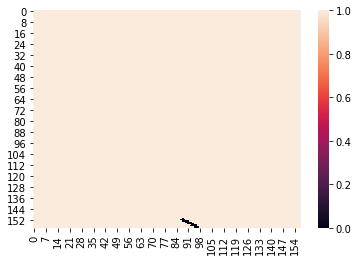

In [6]:
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure

tile = '465X1246Y'
#tile = '412X1198Y'
tile = '449X1239Y'
#tile = '1668X1076Y'
#tile = '1637X1088Y'
tile = '371X1277Y'
#tile = '2283X714Y'
#tile = '369X1279Y'
#tile = '359X1281Y'
#$tile = '2382X944Y'
#tile = '1642X1140Y'
#tile = '2309X679Y'
#tile = '1669X1125Y'

import seaborn as sns
test_x = hkl.load(f"../notebooks/development/{tile}_x.hkl")
test_y = np.load(f"../notebooks/development/{tile}_y.npy")
#for i in range(test_y.shape[0]):
#    test_y[i] = 1 - (binary_dilation(1 - test_y[i], iterations = 1))
sns.heatmap(test_y[2])
#np.save("../notebooks/development/449X1239Y_y.npy", test_y)

In [7]:
idx = 0
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def preprocess_sample(sample, idx):

    med = np.median(sample, axis = 0)
    med = med[np.newaxis, :, :, :]
   # sample = np.concatenate([sample, med], axis = 0)
    
    sample = np.core.umath.clip(sample, min_all, max_all)
    sample = (sample - midrange) / (rng / 2)
    """
    for band in range(0, sample.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        sample[..., band] = np.clip(sample[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (sample[..., band] - midrange) / (rng / 2)
        sample[..., band] = standardized
    """
    return sample


def predict_subtile(subtile: np.ndarray, sess: "tf.Sess", op: "tf.Tensor", size: "int") -> np.ndarray:
    """ Runs temporal (convGRU + UNET) predictions on a (12, 216, 216, 17) array:
        - Calculates remote sensing indices
        - Normalizes data
        - Returns predictions for subtile

        Parameters:
         subtile (np.ndarray): monthly sentinel 2 + sentinel 1 mosaics
         sess (tf.Session): tensorflow session for prediction
    
        Returns:
         preds (np.ndarray): (160, 160) float32 [0, 1] predictions
    """
    #np.save('subtile.npy', subtile)
    if np.sum(subtile) != 0:
        if not isinstance(subtile.flat[0], np.floating):
            print("CONVERTING TO FLOAT")
            assert np.max(subtile) > 1
            subtile = subtile / 65535.

        time1 = time.time()
        subtile = np.core.umath.clip(subtile, min_all, max_all)
        subtile = (subtile - midrange) / (rng / 2)
        batch_x = subtile[np.newaxis].astype(np.float32)
        lengths = np.full((batch_x.shape[0]), args.length)
        #print("length is ", LEN)
        time2 = time.time()
        
        time1 = time.time()
        #preds = sess.run(predict_earlyfeats,
       #                       feed_dict={predict_inp:batch_x, 
        #                                 predict_length:lengths})
        #batch_x = np.delete(batch_x, [11, 12], axis = -1)
        preds = sess.run(op,
                              feed_dict={predict_inp:batch_x, 
                                         predict_length:lengths})

        #preds = sess.run(op,
        #                      feed_dict={predict_inp:batch_x, 
        #                                 predict_length:lengths})


        preds = preds.squeeze()

        clip = (preds.shape[0] - size) // 2
        #preds = preds[1:-1, 1:-1]
        if clip > 0:
            preds = preds[clip:-clip, clip:-clip]
        #preds = np.clip(preds, 0, 1)
        preds = np.float32(preds)
        time2 = time.time()

    else:
        preds = np.full((SIZE, SIZE), 255)
        print(f"The sum of the subtile is {np.sum(subtile)}")
    
    return preds

0.8979673
22416.855 22416.855


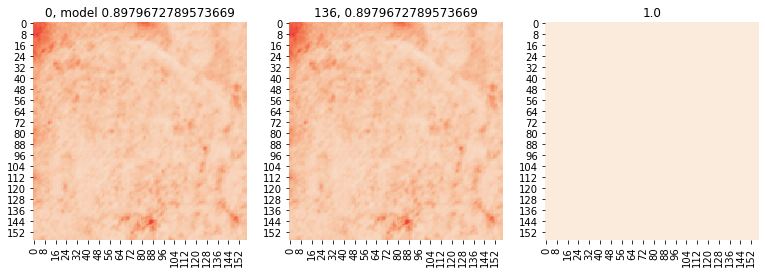

0.81604713
20371.8 20371.8


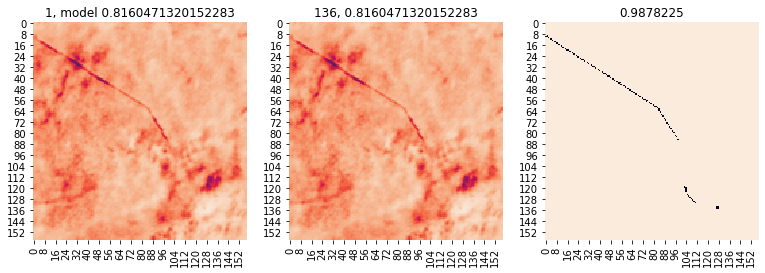

0.8380123
20920.139 20920.139


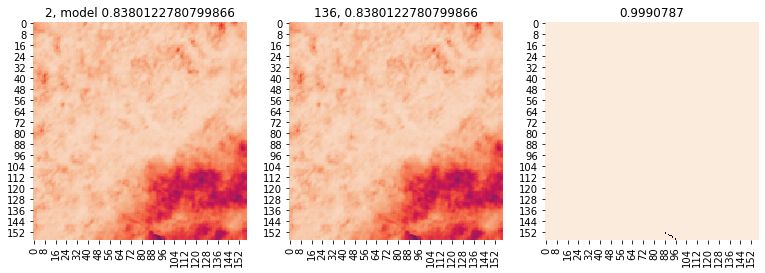

0.7389614
18447.432 18447.432


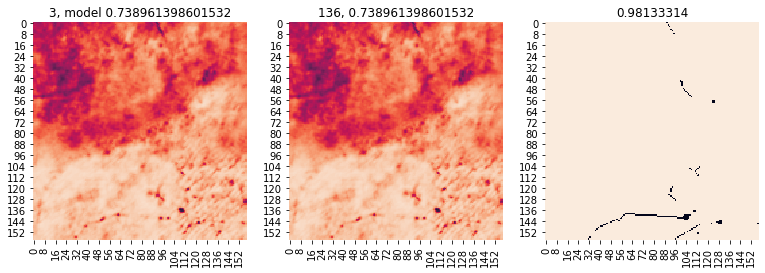

0.807833
20166.744 20166.744


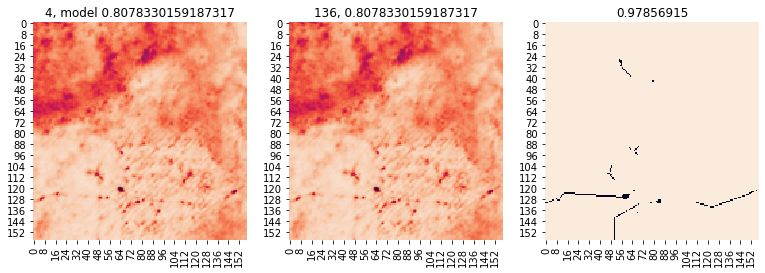

0.8624891
21531.178 21531.178


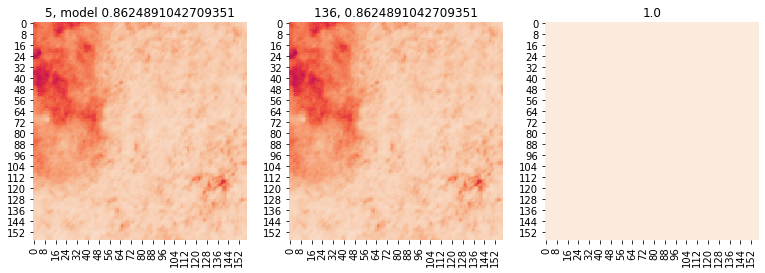

0.8885456
22181.652 22181.652


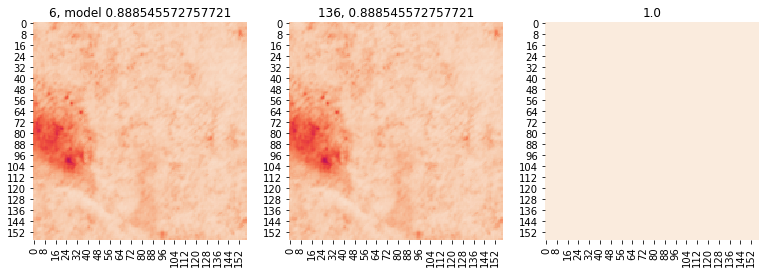

In [8]:
LEN = 4

def augment_sample(sample):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    samples_to_median = np.arange(0,12)##np.random.randint(0, 12, size=(1, 12)) #[32, 6]
    #samples_to_select = np.zeros((1, 4))
    #samples_to_select[:, 0] = np.random.randint(0, 4, size=(1))
    #samples_to_select[:, 1] = np.random.randint(3, 7, size=(1))
    #samples_to_select[:, 2] = np.random.randint(6, 10, size=(1))
    #samples_to_select[:, 3] = np.random.randint(8, 11, size=(1))
    #samples_to_select = samples_to_select.astype(np.int)
    #n_samples = np.random.randint(2, 5, size=(1)) 
    #print(samples_to_select[0])
    SIZE = 172
    x_batch = np.zeros((1, LEN + 1, SIZE, SIZE, 17))
    #print(x_batch.shape)
    med_samp = np.median(sample, axis = 0)
    x_batch[0, 0] = np.median(sample[:3], axis = 0)
    x_batch[0, 1] = np.median(sample[3:6], axis = 0)
    x_batch[0, 2] = np.median(sample[6:9], axis = 0)
    x_batch[0, 3] = np.median(sample[9:], axis = 0)
    #x_batch[0, :-1, ...] = sample[samples_to_select[0]]
    x_batch[0, -1] = med_samp 
    return x_batch

#x_batch_test = augment_sample(x[0])

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.transform
from scipy import ndimage
from scipy.ndimage.morphology import binary_dilation
import scipy
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure
from scipy.ndimage import label, grey_closing
from scipy.ndimage.morphology import binary_dilation, generate_binary_structure

#preds_y = np.zeros((len(files), 14, 14))

#df = pd.read_csv('../data/falsepositives_clean.csv')
#df = df.reset_index(drop = True)
from scipy.ndimage import median_filter, maximum_filter, percentile_filter


#ard_samples = []
idx =  0
plots_remove = []
to_keep = []

train_yout = np.zeros_like(test_y)
for i in range(len(test_x)):
#for i, val in test_data.iterrows():
    sample = np.copy(test_x[i])
    sample = preprocess_sample(sample, 0)[np.newaxis]
    sample = augment_sample(sample.squeeze())

    batch_x = sample#[np.newaxis]
    lengths = np.full((batch_x.shape[0]), 4)
    preds = predict_sess.run(predict_logits,
                          feed_dict={predict_inp:batch_x, 
                                     predict_length:lengths})
    print(np.mean(preds))
    preds2 = predict_sess2.run(predict_logits2,
                          feed_dict={predict_inp2:batch_x, 
                                     predict_length2:lengths})
    print(np.sum(preds), np.sum(preds2))
    if (abs(np.mean(preds) - np.mean(preds2)) >= 0.):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (13, 4))
        sns.heatmap(preds.squeeze(), vmin = 0.0, vmax = 1, ax=ax1, cbar = False)
        sns.heatmap(preds2.squeeze(), vmin = 0.0, vmax = 1, ax=ax2, cbar = False)
        sns.heatmap(maximum_filter(test_y[i], 2), vmin = 0.0, vmax = 1, ax=ax3, cbar = False)
        ax1.set_title(f'{i}, model {np.mean(preds)}')
        ax2.set_title(f'136, {np.mean(preds2)}')
        ax3.set_title(np.mean(test_y[i]))
        #ax4.set_title(np.mean(test_y[i]))
        plt.show()
        to_keep.append(i)